In [1]:
# First reset the pygkyl library
import sys
!rm -rf ~/personal_gkyl_scripts/pygkyl/pygkyl.egg-info
!rm -rf ~/personal_gkyl_scripts/pygkyl/build
!{sys.executable} -m pip install ~/personal_gkyl_scripts/pygkyl > ~/personal_gkyl_scripts/pygkyl/install.log

import numpy as np
import matplotlib.pyplot as plt
import os

# Configure plotting
plt.rcParams["figure.figsize"] = (6,4)

# Custom libraries and routines
import pygkyl

home_dir = os.path.expanduser("~")
repo_dir = home_dir+'/personal_gkyl_scripts/'
# simdir = repo_dir+'sim_data_dir_example/par_adv_test/'
# fileprefix = 'rt_gk_tcv_nt_iwl_3x2v_p1'
simdir = '/Users/ahoffman/personal_gkyl_scripts/sim_data_dir_example/3x2v_example/gk_tcv_posD_iwl_3x2v_electron_heating'
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02'
# simdir = 'sim_data_dir_example/3x2v_example/gk_tcv_nt_high_res_geom/'
# fileprefix = 'rt_gk_tcv_nt_iwl_3x2v_p1'
# simdir = 'sim_data_dir_example/2x2v_example/tcv_NTtq/wk/'
# fileprefix = 'gk_tcv_negD_trueq_iwl_2x2v'
simulation = pygkyl.simulation_configs.import_config('tcv_nt', simdir, fileprefix, dimensionality='3x2v')
# simulation = pygkyl.simulation_configs.import_config('d3d_nt', simdir, fileprefix)
# simulation.geom_param.x_LCFS = 0.08

simulation.normalization.set('t','mus') # time in micro-seconds
simulation.normalization.set('x','minor radius') # radial coordinate normalized by the minor radius (rho=r/a)
simulation.normalization.set('y','Larmor radius') # binormal in term of reference sound Larmor radius
simulation.normalization.set('z','pi') # parallel angle devided by pi
simulation.normalization.set('fluid velocities','thermal velocity') # fluid velocity moments are normalized by the thermal velocity
simulation.normalization.set('temperatures','eV') # temperatures in electron Volt
simulation.normalization.set('pressures','Pa') # pressures in Pascal
simulation.normalization.set('energies','MJ') # energies in mega Joules
simulation.normalization.set('gradients','major radius') # gradients are normalized by the major radius

sim_frames = simulation.available_frames['ion_BiMaxwellianMoments'] # you can check the available frames for each data type like ion_M0, ion_BiMaxwellian, etc.)
print("%g time frames available (%g to %g)"%(len(sim_frames),sim_frames[0],sim_frames[-1]))

232 time frames available (0 to 231)


Reading g-file: /Users/ahoffman/personal_gkyl_scripts/sim_data_dir_example/eqdsk/tcv_nt_65130.eqdsk.txt
Generating equilibrium plot...

--- Miller Geometry Analysis ---
Initial guess for optimization: [0.25, 1.36964846606588, -0.22611521067987017]
Optimization successful. Residual: 0.000515
Calculated amid: 0.2307, Geometric amid: 0.2307
Calculated Parameters:
  amid   = 0.2307 m
  R_axis = 0.8868 m
  Z_axis = 0.1389 m
  R_LCFSmid = 1.0875 m
  ashift = 1.0000
  κ      = 1.3840
  δ      = -0.2592
Using least squares fitting method for Miller parameters.

Saved equilibrium plot to ./equilibrium_plot.png


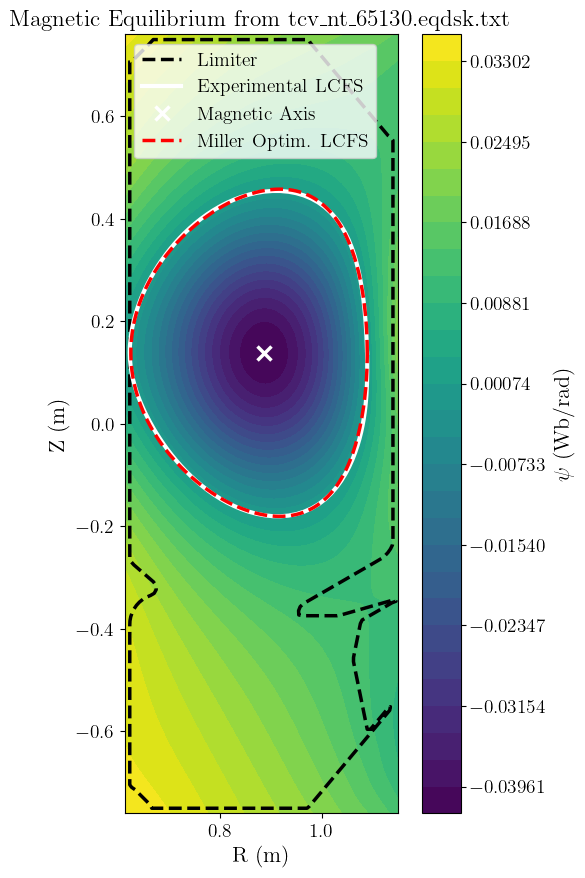


Generating q-profile plot...
Saved q-profile plot to ./q_profile_plot.png


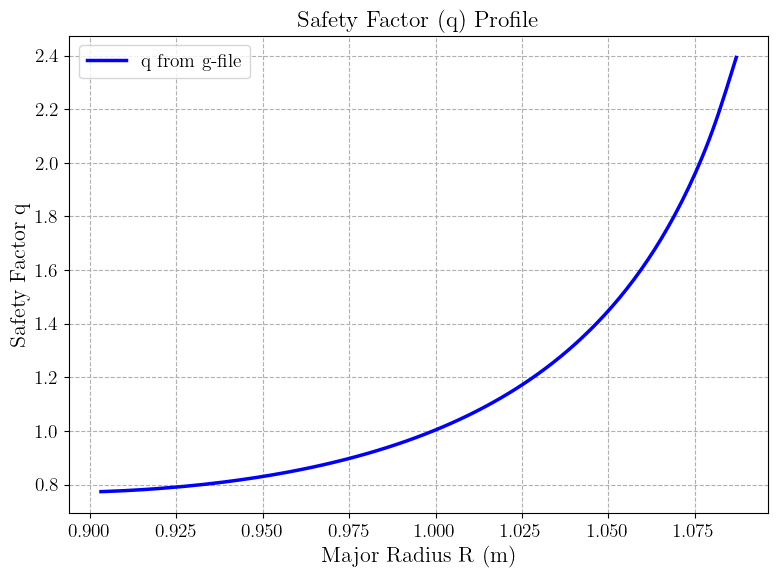

Reading g-file: /Users/ahoffman/personal_gkyl_scripts/sim_data_dir_example/eqdsk/tcv_pt_65125.eqdsk.txt
Generating equilibrium plot...

--- Miller Geometry Analysis ---
Initial guess for optimization: [0.25, 1.3855544684114467, 0.2999826959910534]
Optimization successful. Residual: 0.000593
Calculated amid: 0.2373, Geometric amid: 0.2373
Calculated Parameters:
  amid   = 0.2373 m
  R_axis = 0.8727 m
  Z_axis = 0.1414 m
  R_LCFSmid = 1.0969 m
  ashift = 0.4080
  κ      = 1.3951
  δ      = 0.2826
Using least squares fitting method for Miller parameters.

Saved equilibrium plot to ./equilibrium_plot.png


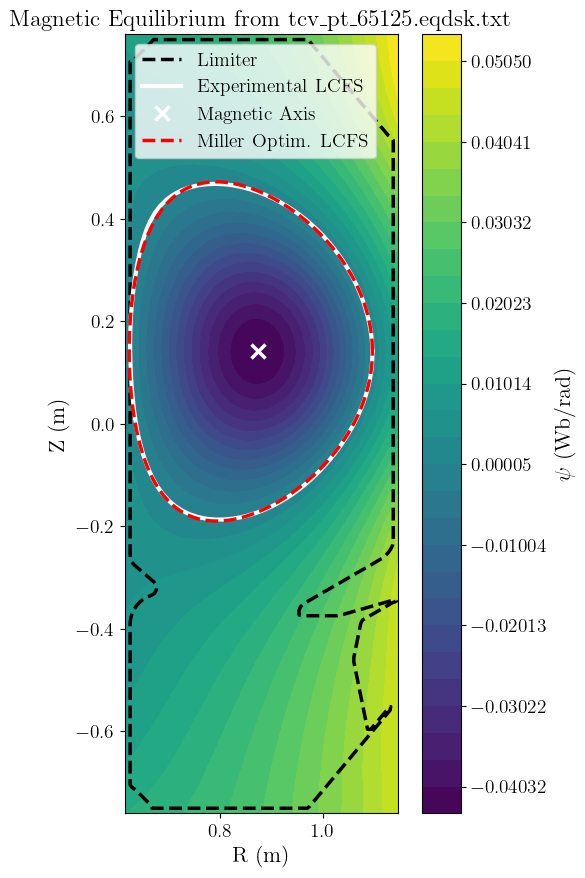


Generating q-profile plot...
Saved q-profile plot to ./q_profile_plot.png


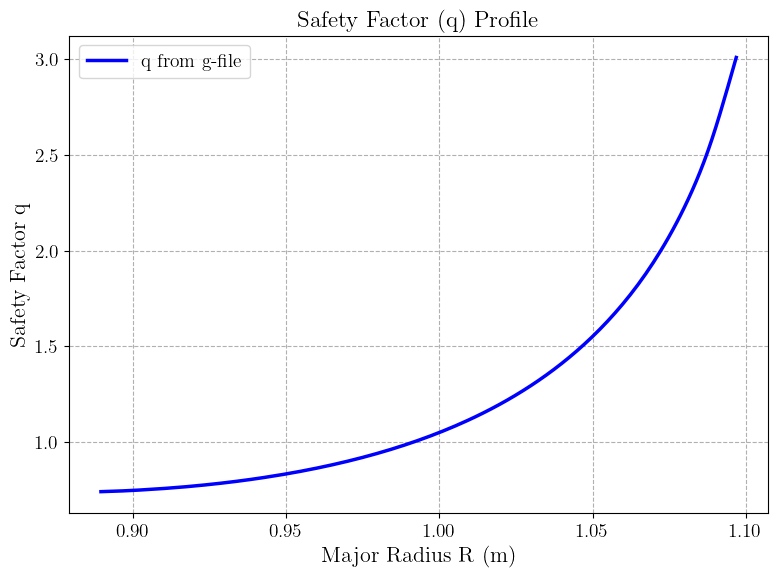

In [6]:
eqdsk_file = '/Users/ahoffman/personal_gkyl_scripts/sim_data_dir_example/eqdsk/tcv_nt_65130.eqdsk.txt'
pygkyl.eqdsk_tools.plot_equilibrium_and_q_profile(eqdsk_file, fit_method='optimization')

eqdsk_file = '/Users/ahoffman/personal_gkyl_scripts/sim_data_dir_example/eqdsk/tcv_pt_65125.eqdsk.txt'
pygkyl.eqdsk_tools.plot_equilibrium_and_q_profile(eqdsk_file, fit_method='optimization')

field_fs shape: (32, 768), phi_fs shape: (32, 768), theta_fs shape: (32, 768)


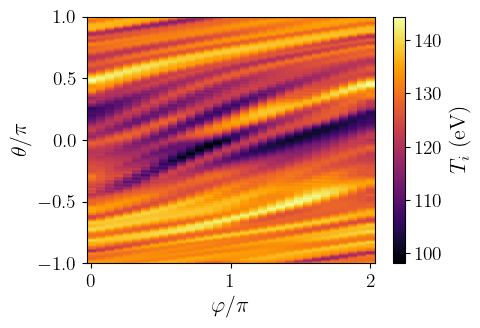

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fsproj = pygkyl.FluxSurfProjection()
fieldname = 'Ti'
rho = 0.9
Nint = 32
overSampFact = 2
timeFrame = sim_frames[-1]
fsproj.setup(simulation, Nint=Nint, rho=rho, smooth=True)
fsproj.plot(fieldName=fieldname, timeFrame=timeFrame, fluctuation='')

field_fs, phi_fs, theta_fs = fsproj.get_projection(fieldName=fieldname, timeFrame=timeFrame)
# check shapes
print(f'field_fs shape: {field_fs.shape}, phi_fs shape: {phi_fs.shape}, theta_fs shape: {theta_fs.shape}')

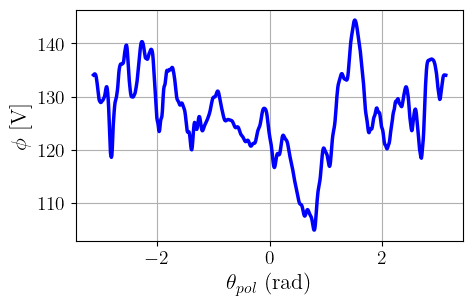

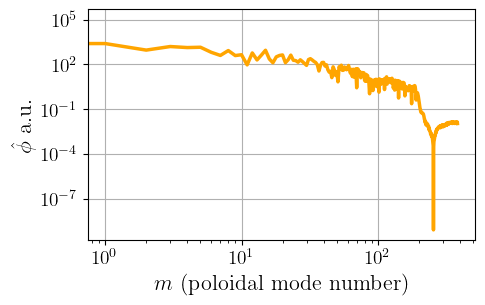

In [4]:
# average over theta
#field_fs_avg = np.mean(field_fs, axis=1)  # Average over the theta dimension
#th0 = 0.0
#i0 = np.argmin(np.abs(theta_fs[0,:] - th0))  # Find the index closest to pi/2
i0 = 0
field_fs_avg = field_fs[i0,:]
#field_fs_avg = np.mean(field_fs, axis=0)  # Average over the theta dimension

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(theta_fs[0,:],field_fs_avg, label='Field Projection', color='blue')
ax.set_xlabel(r'$\theta_{pol}$ (rad)')
ax.set_ylabel(r'$\phi$ [V]')
plt.grid()
plt.show()

# Analyse the fourier transform of the flux surface projection
field_fs_fft = np.fft.rfft(field_fs_avg,axis=0)  # Perform FFT along the poloidal mode number
plt.figure(figsize=(5,3))
plt.plot(np.abs(field_fs_fft), label='FFT of Field Projection', color='orange')
plt.xlabel(r'$m$ (poloidal mode number)')
plt.ylabel(r'$\hat\phi$ a.u.')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()